In [ ]:
%pip install pyspark
%pip install pyspark_dist_explore 

Python interpreter will be restarted.
  Using cached pyspark-3.4.0-py2.py3-none-any.whl
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
Python interpreter will be restarted.
Python interpreter will be restarted.
  Using cached pyspark_dist_explore-0.1.8-py3-none-any.whl (7.2 kB)
Python interpreter will be restarted.
Python interpreter will be restarted.
  Using cached mlflow-2.4.1-py3-none-any.whl (18.1 MB)
  Using cached gunicorn-20.1.0-py3-none-any.whl (79 kB)
  Using cached docker-6.1.3-py3-none-any.whl (148 kB)
  Using cached PyYAML-6.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (661 kB)
  Using cached GitPython-3.1.31-py3-none-any.whl (184 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached alembic-1.11.1-py3-none-any.whl (224 kB)
  Using cached Flask-2.3.2-py3-none-any.whl (96 kB)
  Using cached Markdown-3.4.3-py3-none-any.whl (93 kB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.w

In [ ]:
from pyspark import SparkContext
from pyspark.sql import functions as f, SparkSession, Column
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.ml.fpm import FPGrowth

In [ ]:
# Create a spark session. All sorts of settings can be specified here. 
spark = SparkSession.builder.appName("Marketbasket").getOrCreate()

In [ ]:
df = spark.read.csv("data/basket.csv", header=True).withColumn("id", f.monotonically_increasing_id())
df_all = spark.read.csv("data/Groceries_data.csv", header=True).withColumn("id", f.monotonically_increasing_id())

df.show(5)
df_all.show(5)

+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
|          0|                 1|                  2|     3|   4|   5|   6|   7|   8|   9|  10| id|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
| whole milk|            pastry|        salty snack|  null|null|null|null|null|null|null|null|  0|
|    sausage|        whole milk|semi-finished bread|yogurt|null|null|null|null|null|null|null|  1|
|       soda|pickled vegetables|               null|  null|null|null|null|null|null|null|null|  2|
|canned beer|   misc. beverages|               null|  null|null|null|null|null|null|null|null|  3|
|    sausage|  hygiene articles|               null|  null|null|null|null|null|null|null|null|  4|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
only showing top 5 rows

+-------------+----------+----------------+----+-----+---+-----------+---+
|Member_n

In [ ]:
num_baskets = df_all.groupBy("Member_number").count()
num_baskets.show(5)

+-------------+-----+
|Member_number|count|
+-------------+-----+
|         2904|   10|
|         3959|   14|
|         2294|   23|
|         4032|    4|
|         1512|   10|
+-------------+-----+
only showing top 5 rows



Out[5]: (array([302., 328., 178., 371., 237., 341., 251., 538., 252., 192., 179.,
        144., 136., 109.,  69., 110.,  49.,  23.,  29.,  14.,  11.,   9.,
         13.,   4.,   1.,   4.,   0.,   3.,   0.,   1.]),
 array([ 2.        ,  3.13333333,  4.26666667,  5.4       ,  6.53333333,
         7.66666667,  8.8       ,  9.93333333, 11.06666667, 12.2       ,
        13.33333333, 14.46666667, 15.6       , 16.73333333, 17.86666667,
        19.        , 20.13333333, 21.26666667, 22.4       , 23.53333333,
        24.66666667, 25.8       , 26.93333333, 28.06666667, 29.2       ,
        30.33333333, 31.46666667, 32.6       , 33.73333333, 34.86666667,
        36.        ]),
 <BarContainer object of 30 artists>)

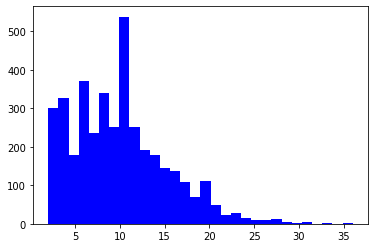

In [ ]:
fig, ax = plt.subplots()

hist(ax, num_baskets.select('count'), bins = 30, color=['blue'])

In [ ]:
df_basket = df.select("id", f.array([df[c] for c in df.columns[:11]]).alias("basket"))
df_basket.printSchema()
# False tells show() to not truncate the columns when printing.
df_basket.show(3, False) 

root
 |-- id: long (nullable = false)
 |-- basket: array (nullable = false)
 |    |-- element: string (containsNull = true)

+---+--------------------------------------------------------------------------------------------+
|id |basket                                                                                      |
+---+--------------------------------------------------------------------------------------------+
|0  |[whole milk, pastry, salty snack, null, null, null, null, null, null, null, null]           |
|1  |[sausage, whole milk, semi-finished bread, yogurt, null, null, null, null, null, null, null]|
|2  |[soda, pickled vegetables, null, null, null, null, null, null, null, null, null]            |
+---+--------------------------------------------------------------------------------------------+
only showing top 3 rows



In [ ]:
df_aggregated = df_basket.select("id", f.array_except("basket", f.array(f.lit(None))).alias("basket"))
df_aggregated.show(3, False)

+---+--------------------------------------------------+
|id |basket                                            |
+---+--------------------------------------------------+
|0  |[whole milk, pastry, salty snack]                 |
|1  |[sausage, whole milk, semi-finished bread, yogurt]|
|2  |[soda, pickled vegetables]                        |
+---+--------------------------------------------------+
only showing top 3 rows



In [ ]:
# Run FPGrowth and fit the model.
fp = FPGrowth(minSupport=0.001, minConfidence=0.001, itemsCol='basket', predictionCol='prediction')
model = fp.fit(df_aggregated)

In [ ]:
# View a subset of the frequent itemset. 
model.freqItemsets.show(50, False)

+-----------------------------+----+
|items                        |freq|
+-----------------------------+----+
|[cocoa drinks]               |16  |
|[canned fruit]               |21  |
|[specialty cheese]           |72  |
|[chocolate marshmallow]      |60  |
|[pet care]                   |85  |
|[house keeping products]     |45  |
|[jam]                        |34  |
|[light bulbs]                |29  |
|[beef]                       |508 |
|[beef, frankfurter]          |15  |
|[beef, rolls/buns]           |24  |
|[beef, domestic eggs]        |17  |
|[beef, root vegetables]      |25  |
|[beef, bottled beer]         |16  |
|[beef, canned beer]          |15  |
|[beef, yogurt]               |33  |
|[beef, fruit/vegetable juice]|16  |
|[beef, newspapers]           |25  |
|[beef, bottled water]        |20  |
|[beef, pastry]               |18  |
|[beef, other vegetables]     |42  |
|[beef, brown bread]          |23  |
|[beef, citrus fruit]         |27  |
|[beef, shopping bags]        |19  |
|

In [ ]:
# Use filter to view just the association rules with the highest confidence.
model.associationRules.filter(model.associationRules.confidence>0.15).show(20, False)

+---------------------+------------+-------------------+------------------+---------------------+
|antecedent           |consequent  |confidence         |lift              |support              |
+---------------------+------------+-------------------+------------------+---------------------+
|[bottled beer]       |[whole milk]|0.15781710914454278|0.9993302598941151|0.007150972398583172 |
|[detergent]          |[whole milk]|0.16279069767441862|1.030824041177455 |0.001403461872619127 |
|[semi-finished bread]|[whole milk]|0.176056338028169  |1.1148247930239072|0.001670787943594199 |
|[sausage, rolls/buns]|[whole milk]|0.2125             |1.345593525179856 |0.0011361358016440553|
|[sausage, soda]      |[whole milk]|0.1797752808988764 |1.1383739010113787|0.0010693042839002875|
|[ham]                |[whole milk]|0.16015625         |1.0141421789039358|0.0027400922274944863|
|[frozen fish]        |[whole milk]|0.1568627450980392 |0.9932870312746344|0.0010693042839002875|
|[sausage, whole mil

In [ ]:
# Create a PySpark dataframe
columns = ['basket']
# new_data = [(['ham', 'yogurt', 'light bulbs'],), (['jam', 'cocoa drinks', 'pet care'],)]
new_data = [(['beef'],), (['oil'],)]
rdd = spark.sparkContext.parallelize(new_data)
new_df = rdd.toDF(columns)
new_df.printSchema()
new_df.show(2,False)

root
 |-- basket: array (nullable = true)
 |    |-- element: string (containsNull = true)

+------+
|basket|
+------+
|[beef]|
|[oil] |
+------+



In [ ]:
# Generate predictions using the model
predictions = model.transform(new_df)

# Show the recommendations
predictions.show(5)

+------+--------------------+
|basket|          prediction|
+------+--------------------+
|[beef]|[frankfurter, rol...|
| [oil]|[rolls/buns, yogu...|
+------+--------------------+



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

# Evaluate the predictions using lift
association_rules = model.associationRules

# Join the association rules with the predictions based on the common items
eval_df = association_rules.join(predictions, association_rules.antecedent == predictions.basket, "inner")

# Calculate the lift for each association rule
# eval_df = eval_df.withColumn("lift", col("confidence") / association_rules.select("confidence").first())

# Show the evaluation results
eval_df.show()


+----------+--------------------+--------------------+-------------------+--------------------+------+--------------------+
|antecedent|          consequent|          confidence|               lift|             support|basket|          prediction|
+----------+--------------------+--------------------+-------------------+--------------------+------+--------------------+
|    [beef]|              [curd]| 0.03740157480314961|  1.110396356705412|0.001269798837131...|[beef]|[frankfurter, rol...|
|    [beef]| [frozen vegetables]| 0.03740157480314961| 1.3356557608103283|0.001269798837131...|[beef]|[frankfurter, rol...|
|    [beef]|         [margarine]| 0.04133858267716536| 1.2832971215734963|0.001403461872619127|[beef]|[frankfurter, rol...|
|    [beef]|        [whole milk]|  0.1377952755905512| 0.8725479088706803|0.004678206242063757|[beef]|[frankfurter, rol...|
|    [beef]|[whipped/sour cream]| 0.04133858267716536| 0.9457939030556961|0.001403461872619127|[beef]|[frankfurter, rol...|
|    [be

In [ ]:
# Stop the Spark session
spark.stop()